<a href="https://colab.research.google.com/github/nemoiitkgp/FWI-Codes-PhD/blob/main/Anticline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install deepwave scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 21.4 MB/s eta 0:00:00


Device: cuda
Keys found in .mat file: ['dx', 'dz', 'fmat']
Validated Model shape (nx, nz) = 850 x 404
Velocity range: 1500.0 to 2800.0 m/s


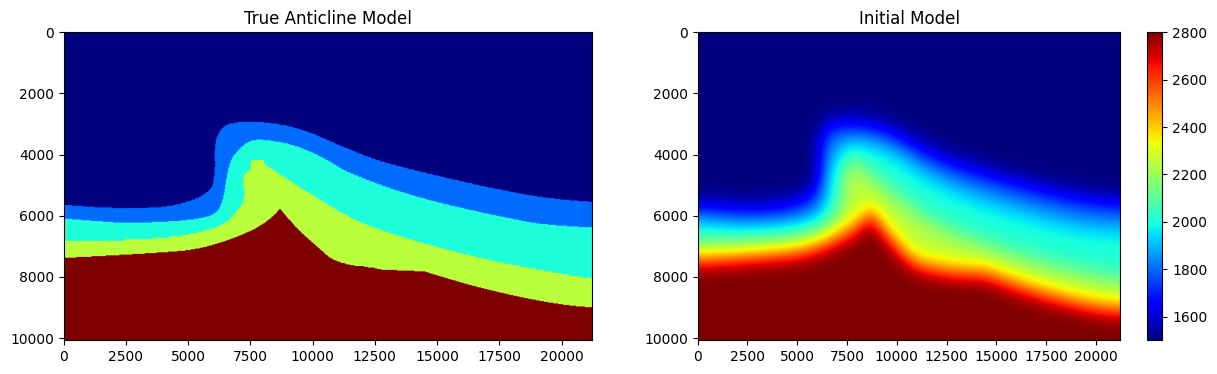

Generating observed data...
Starting Inversion...


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.95 GiB. GPU 0 has a total capacity of 14.56 GiB of which 5.22 GiB is free. Including non-PyTorch memory, this process has 9.34 GiB memory in use. Of the allocated memory 9.17 GiB is allocated by PyTorch, and 59.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# 1. INSTALL LIBRARIES
!pip install deepwave

# 2. LIBRARIES AND SETTINGS
import numpy as np
import torch
import scipy.io
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# Device: GPU if available (T4 on Colab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 3. INPUT: ANTICLINE MODEL (.mat file)
mat_path = 'anticline_model.mat'

try:
    mat = scipy.io.loadmat(mat_path)
    print("Keys found in .mat file:", [k for k in mat.keys() if "__" not in k])

    # Logic to find the actual velocity array (the largest 2D array)
    v_true_np = None
    max_size = 0
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            # Squeeze to remove dimensions of size 1 (e.g., (187, 801, 1) -> (187, 801))
            arr = np.squeeze(mat[key])
            if arr.ndim == 2 and arr.size > max_size:
                v_true_np = arr.astype(np.float32)
                max_size = arr.size

    if v_true_np is None:
        raise ValueError("Could not find a valid 2D velocity array in the .mat file.")

    # Unit Correction: If values are ~2.0, they are likely km/s. Convert to m/s.
    if np.max(v_true_np) < 10:
        print("Detected velocity in km/s. Converting to m/s...")
        v_true_np *= 1000.0

except FileNotFoundError:
    print(f"Error: {mat_path} not found. Please upload it to the 'Files' tab in Colab.")
    raise

# Convert to torch.
# Deepwave usually expects (nx, nz). If your mat is (nz, nx), transpose it.
v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: # Heuristic: usually width > depth
    v_true = v_true.T

nx, nz = v_true.shape
print(f"Validated Model shape (nx, nz) = {nx} x {nz}")

# Grid spacing
dx, dz = 25.0, 25.0
spacing = (dx, dz)
extent = [0, (nx - 1) * dx, (nz - 1) * dz, 0]

# 4. INITIAL VELOCITY MODEL
v_init = (torch.tensor(1/gaussian_filter(1/v_true.cpu().numpy(), sigma=15)).to(device))
v1 = v_init.clone()
v1.requires_grad_()

vmin_plot, vmax_plot = v_true.min().item(), v_true.max().item()
print(f"Velocity range: {vmin_plot:.1f} to {vmax_plot:.1f} m/s")

# PLOT
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.imshow(v_true.cpu().T, cmap='jet', aspect='auto', vmin=vmin_plot, vmax=vmax_plot, extent=extent)
ax1.set_title('True Anticline Model')
im2 = ax2.imshow(v1.detach().cpu().T, cmap='jet', aspect='auto', vmin=vmin_plot, vmax=vmax_plot, extent=extent)
ax2.set_title('Initial Model')
plt.colorbar(im2, ax=ax2)
plt.show()

# 5. ACQUISITION GEOMETRY
n_shots = 20
n_sources_per_shot = 1
n_receivers_per_shot = nx # All surface receivers
freq = 5.0
dt = 0.002
nt = 1500
peak_time = 1.5/freq

source_loc = torch.zeros(n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device)
source_loc[..., 1] = 2
source_loc[:, 0, 0] = torch.linspace(0, nx - 1, n_shots).round()

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 2
receiver_loc[:, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).round()

source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time)
              .repeat(n_shots, n_sources_per_shot, 1).to(device))

# 6. FORWARD MODELLING (BATTERED)
print("Generating observed data...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
batch_size = 4

with torch.no_grad():
    for i in range(0, n_shots, batch_size):
        out = scalar(v_true, spacing, dt,
                     source_amplitudes=source_amp[i:i+batch_size],
                     source_locations=source_loc[i:i+batch_size],
                     receiver_locations=receiver_loc[i:i+batch_size],
                     accuracy=4, pml_freq=freq)
        observed_data[i:i+batch_size] = out[-1]
        torch.cuda.empty_cache()

# 7. INVERSION
def taper(x): return deepwave.common.cosine_taper_end(x, 15)
observed_data_tapered = taper(observed_data)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam([v1], lr=15.0)

print("Starting Inversion...")
for epoch in range(600): # 600 iterations for a good balance of time/quality
    optimiser.zero_grad()
    epoch_loss = 0
    for i in range(0, n_shots, batch_size):
        out_pred = scalar(v1, spacing, dt,
                          source_amplitudes=source_amp[i:i+batch_size],
                          source_locations=source_loc[i:i+batch_size],
                          receiver_locations=receiver_loc[i:i+batch_size],
                          accuracy=4, pml_freq=freq)
        loss = loss_fn(taper(out_pred[-1]), observed_data_tapered[i:i+batch_size])
        loss = loss / (n_shots / batch_size)
        loss.backward()
        epoch_loss += loss.item()

    with torch.no_grad():
        grad_smoothed = gaussian_filter(v1.grad.cpu().numpy(), sigma=1.5)
        v1.grad.copy_(torch.tensor(grad_smoothed).to(device))
        v1.clamp_(min=vmin_plot, max=vmax_plot)

    optimiser.step()
    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1} | Loss: {epoch_loss:.6f}")

# 8. FINAL RESULTS
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].imshow(v_true.cpu().T, cmap='jet', aspect='auto', extent=extent)
ax[0].set_title("True Model")
ax[1].imshow(v1.detach().cpu().T, cmap='jet', aspect='auto', extent=extent)
ax[1].set_title("Inverted Model")
plt.tight_layout()
plt.show()

Device: cuda
Model shape (nx, nz) = 850 x 404
Generating observed data...
Starting Inversion (Memory Optimized)...
Epoch 100 | Loss: 0.000000
Epoch 200 | Loss: 0.000000
Epoch 300 | Loss: 0.000000
Epoch 400 | Loss: 0.000000


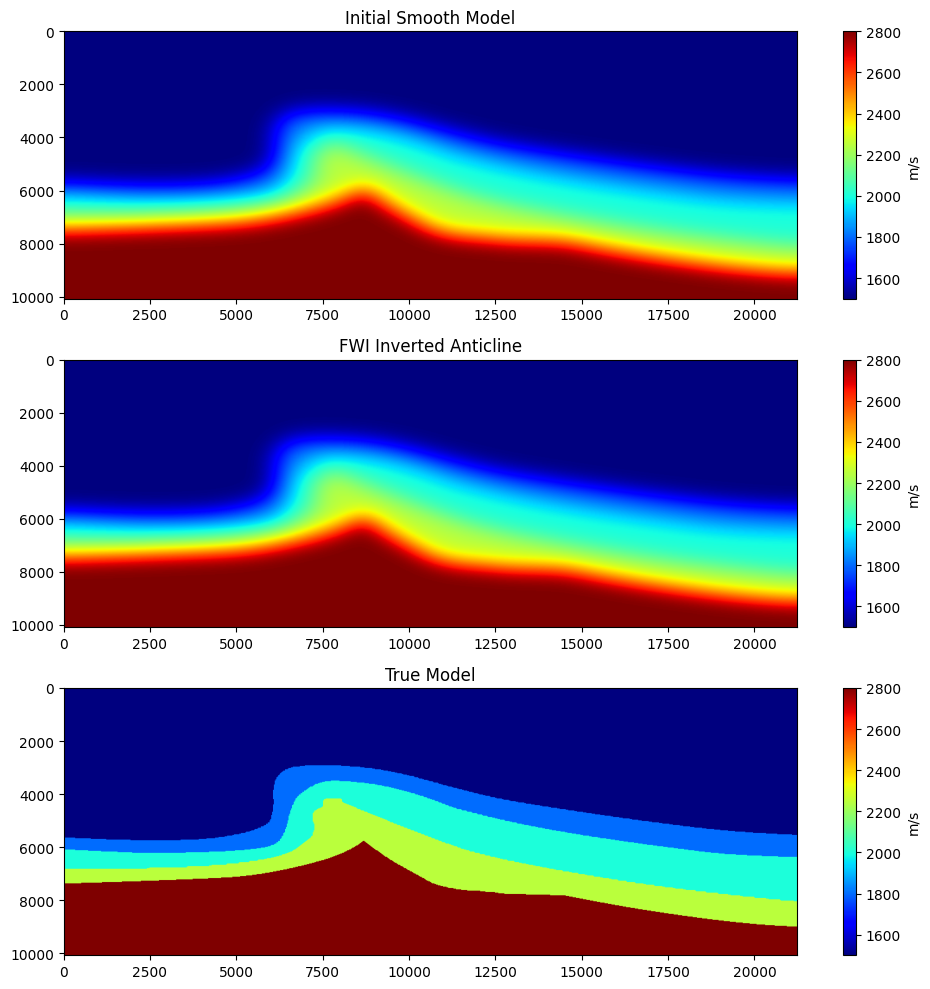

In [ ]:
# 1. INSTALL LIBRARIES
!pip install deepwave

# 2. LIBRARIES AND SETTINGS
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# Device: GPU if available (T4 on Colab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 3. INPUT: ANTICLINE MODEL (.mat file)
mat_path = 'anticline_model.mat'

try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    max_size = 0
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2 and arr.size > max_size:
                v_true_np = arr.astype(np.float32)
                max_size = arr.size

    if v_true_np is None:
        raise ValueError("Could not find a valid 2D velocity array.")

    if np.max(v_true_np) < 10: # Convert km/s to m/s
        v_true_np *= 1000.0
except FileNotFoundError:
    print(f"Error: {mat_path} not found.")
    raise

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T

nx, nz = v_true.shape
print(f"Model shape (nx, nz) = {nx} x {nz}")

dx, dz = 25.0, 25.0
spacing = (dx, dz)
extent = [0, (nx - 1) * dx, (nz - 1) * dz, 0]

# 4. INITIAL VELOCITY MODEL
v_init = (torch.tensor(1/gaussian_filter(1/v_true.cpu().numpy(), sigma=15)).to(device))
v1 = v_init.clone()
v1.requires_grad_()

vmin_plot, vmax_plot = v_true.min().item(), v_true.max().item()

# 5. ACQUISITION GEOMETRY
n_shots = 15 # Reduced shot count slightly to speed up inversion
n_sources_per_shot = 1
n_receivers_per_shot = nx
freq = 5.0
dt = 0.002
nt = 750 # REDUCED to save memory (1.5 seconds of recording)
peak_time = 1.5/freq

source_loc = torch.zeros(n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device)
source_loc[..., 1] = 2
source_loc[:, 0, 0] = torch.linspace(0, nx - 1, n_shots).round()

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 2
receiver_loc[:, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).round()

source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time)
              .repeat(n_shots, n_sources_per_shot, 1).to(device))

# 6. FORWARD MODELLING
print("Generating observed data...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)

with torch.no_grad():
    for i in range(n_shots):
        out = scalar(v_true, spacing, dt,
                     source_amplitudes=source_amp[i:i+1],
                     source_locations=source_loc[i:i+1],
                     receiver_locations=receiver_loc[i:i+1],
                     accuracy=4, pml_freq=freq, pml_width=[20, 20, 20, 20])
        observed_data[i:i+1] = out[-1]
        torch.cuda.empty_cache()

# 7. INVERSION
def taper(x): return deepwave.common.cosine_taper_end(x, 15)
observed_data_tapered = taper(observed_data)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam([v1], lr=15.0)

print("Starting Inversion (Memory Optimized)...")
for epoch in range(400):
    optimiser.zero_grad()
    epoch_loss = 0

    # Process one shot at a time (Batch Size 1) to fit in 15GB VRAM
    for i in range(n_shots):
        out_pred = scalar(v1, spacing, dt,
                          source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1],
                          receiver_locations=receiver_loc[i:i+1],
                          accuracy=4, pml_freq=freq,
                          pml_width=[20, 20, 20, 20])

        loss = loss_fn(taper(out_pred[-1]), observed_data_tapered[i:i+1])
        loss = loss / n_shots
        loss.backward() # This is where memory peaks
        epoch_loss += loss.item()

        # Free memory from the forward pass result
        del out_pred
        torch.cuda.empty_cache()

    # Gradient Post-processing
    with torch.no_grad():
        grad_np = gaussian_filter(v1.grad.cpu().numpy(), sigma=1.5)
        v1.grad.copy_(torch.tensor(grad_np).to(device))
        v1.clamp_(min=vmin_plot, max=vmax_plot)

    optimiser.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1} | Loss: {epoch_loss:.6f}")
        gc.collect()

# 8. FINAL PLOTTING
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
imgs = [v_init.cpu(), v1.detach().cpu(), v_true.cpu()]
titles = ["Initial Smooth Model", "FWI Inverted Anticline", "True Model"]

for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin_plot, vmax=vmax_plot, extent=extent)
    ax[i].set_title(titles[i])
    fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout()
plt.show()

Device: cuda
Generating data for 4.5 seconds...
Starting Full-Model Inversion...
Epoch 010 | Loss: 1.7389e-01
Epoch 020 | Loss: 4.5095e-02
Epoch 030 | Loss: 1.9675e-02
Epoch 040 | Loss: 9.8240e-03
Epoch 050 | Loss: 5.9308e-03
Epoch 060 | Loss: 4.1868e-03
Epoch 070 | Loss: 3.0433e-03
Epoch 080 | Loss: 2.3048e-03
Epoch 090 | Loss: 1.8645e-03
Epoch 100 | Loss: 1.5888e-03


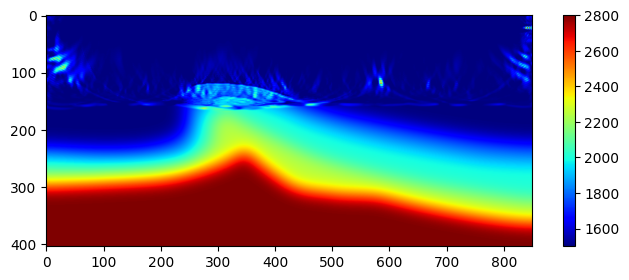

KeyboardInterrupt: 

In [ ]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 250:] = 3500 # Deep layer

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape

# 3. INITIAL MODEL
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=15)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)
vmin, vmax = v_true.min().item(), v_true.max().item()

# 4. GEOMETRY (Optimized for Depth)
pml_v = 20
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.003  # Increased dt slightly to allow longer time without OOM
nt = 1500   # INCREASED: 1500 * 0.003 = 4.5 seconds (Enough to see deeper layers)
freq = 5.0
n_shots = 15

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 2
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 2
for i in range(n_shots): receiver_loc[i, :, 0] = rx

source_amp = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1).to(device)

# 5. GENERATE OBSERVED DATA
print(f"Generating data for {nt*dt} seconds...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
with torch.no_grad():
    for i in range(n_shots):
        out = scalar(v_true, spacing, dt, source_amplitudes=source_amp[i:i+1],
                     source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data[i] = out[-1]

initial_loss = 0
with torch.no_grad():
    for i in range(n_shots):
        out_init = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        initial_loss += torch.nn.MSELoss()(out_init[-1], observed_data[i:i+1]).item()

# 6. DEPTH PRECONDITIONING (THE KEY TO DEEP INVERSION)
# Create a gain that increases with depth to boost deep gradients
z_gain = torch.linspace(1.0, 5.0, nz, device=device).view(1, nz)

# 7. INVERSION
optimizer = torch.optim.Adam([v1], lr=35.0)
loss_history = []

print("Starting Full-Model Inversion...")
for epoch in range(400):
    optimizer.zero_grad()
    epoch_loss = 0
    for i in range(n_shots):
        out_pred = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        loss = torch.nn.MSELoss()(out_pred[-1], observed_data[i:i+1])
        (loss / (initial_loss / n_shots)).backward()
        epoch_loss += loss.item()
        del out_pred

    # Gradient Processing
    with torch.no_grad():
        if v1.grad is not None:
            # 1. Apply depth gain to force updates at the bottom
            v1.grad *= z_gain

            # 2. Smooth gradient
            grad = gaussian_filter(v1.grad.cpu().numpy(), sigma=2.0)
            v1.grad.copy_(torch.from_numpy(grad).to(device))

            # 3. Update and Clamp
            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    loss_history.append(epoch_loss)
    if (epoch + 1) % 10 == 0: print(f"Epoch {epoch+1:03d} | Loss: {epoch_loss:.4e}")
    if (epoch + 1) % 100 == 0:
        plt.figure(figsize=(8,3)); plt.imshow(v1.detach().cpu().numpy().T, cmap='jet'); plt.colorbar(); plt.show()
        gc.collect(); torch.cuda.empty_cache()

# 8. FINAL PLOTS
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = ["Initial (Smooth)", "Final (Inverted Top-to-Bottom)", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i]); fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout(); plt.show()

Device: cuda
Generating data for 7.5 seconds (Deep Illumination)...
Starting Top-to-Bottom Inversion...
Epoch 010 | Norm Loss: 13.1125
Epoch 020 | Norm Loss: 4.9586
Epoch 030 | Norm Loss: 2.6244
Epoch 040 | Norm Loss: 1.7224
Epoch 050 | Norm Loss: 1.2729


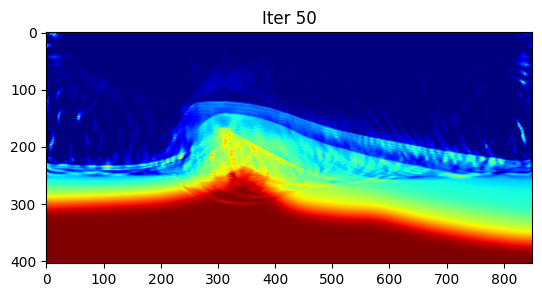

Epoch 060 | Norm Loss: 1.0508
Epoch 070 | Norm Loss: 0.9208
Epoch 080 | Norm Loss: 0.8478
Epoch 090 | Norm Loss: 0.8083
Epoch 100 | Norm Loss: 0.7930


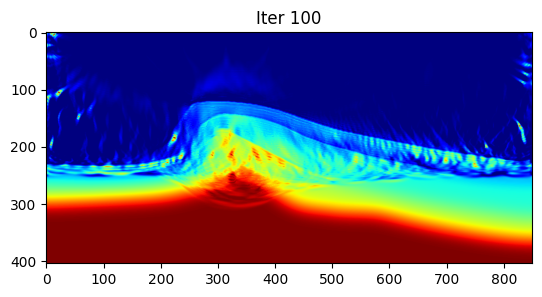

KeyboardInterrupt: 

In [6]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 200:] = 3500

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape

# 3. INITIAL MODEL
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=15)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)
vmin, vmax = v_true.min().item(), v_true.max().item()

# 4. GEOMETRY (CRITICAL FOR DEPTH)
pml_v = 20
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.003
nt = 2500   # 2500 * 0.003 = 7.5 SECONDS. Essential to reach 10km depth.
freq = 5.0
n_shots = 12 # Fewer shots to save memory for the long time duration

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 2
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 2
for i in range(n_shots): receiver_loc[i, :, 0] = rx

source_amp = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1).to(device)

# 5. GENERATE DATA
print(f"Generating data for {nt*dt} seconds (Deep Illumination)...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
with torch.no_grad():
    for i in range(n_shots):
        out = scalar(v_true, spacing, dt, source_amplitudes=source_amp[i:i+1],
                     source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data[i] = out[-1]

# Pre-calculate initial loss for normalization
with torch.no_grad():
    initial_loss = 0
    for i in range(n_shots):
        out_init = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        initial_loss += torch.nn.MSELoss()(out_init[-1], observed_data[i:i+1]).item()
    initial_loss /= n_shots

# 6. DEPTH PRECONDITIONING
# We use a quadratic gain (z^2) to boost deep gradients significantly
z = torch.linspace(0, 1, nz, device=device)
z_gain = (1.0 + 10.0 * z**2).view(1, nz) # 1x at surface, 11x at bottom

# 7. INVERSION
optimizer = torch.optim.Adam([v1], lr=40.0) # High LR for deep structures
loss_history = []

print("Starting Top-to-Bottom Inversion...")
for epoch in range(300):
    optimizer.zero_grad()
    epoch_loss = 0

    for i in range(n_shots):
        out_pred = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)

        loss = torch.nn.MSELoss()(out_pred[-1], observed_data[i:i+1])
        (loss / initial_loss).backward()
        epoch_loss += (loss / initial_loss).item()
        del out_pred

    # Process Gradient
    with torch.no_grad():
        if v1.grad is not None:
            v1.grad *= z_gain # Boost deep updates
            grad = gaussian_filter(v1.grad.cpu().numpy(), sigma=2.5)
            v1.grad.copy_(torch.from_numpy(grad).to(device))
            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    loss_history.append(epoch_loss)
    if (epoch + 1) % 10 == 0: print(f"Epoch {epoch+1:03d} | Norm Loss: {epoch_loss:.4f}")
    if (epoch + 1) % 50 == 0:
        plt.figure(figsize=(8,3)); plt.imshow(v1.detach().cpu().numpy().T, cmap='jet'); plt.title(f"Iter {epoch+1}"); plt.show()
        gc.collect(); torch.cuda.empty_cache()

# 8. FINAL PLOTS
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = ["Initial Smooth", "FWI Final (Full Depth)", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i]); fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout(); plt.show()

In [9]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 200:] = 3500

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape

# 3. INITIAL MODEL
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=15)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)
vmin, vmax = v_true.min().item(), v_true.max().item()

# 4. GEOMETRY (CRITICAL FOR DEPTH)
pml_v = 20
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.003
nt = 2667   # 2667 * 0.003 = 8.001 SECONDS. Essential to reach 10km+ depth.
freq = 5.0
n_shots = 12 # Fewer shots to save memory for the long time duration

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 2
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 2
for i in range(n_shots): receiver_loc[i, :, 0] = rx

source_amp = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1).to(device)

# 5. GENERATE DATA
print(f"Generating data for {nt*dt:.2f} seconds (Deep Illumination)...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
with torch.no_grad():
    for i in range(n_shots):
        out = scalar(v_true, spacing, dt, source_amplitudes=source_amp[i:i+1],
                     source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data[i] = out[-1]

# Pre-calculate initial loss for normalization
with torch.no_grad():
    initial_loss = 0
    for i in range(n_shots):
        out_init = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        initial_loss += torch.nn.MSELoss()(out_init[-1], observed_data[i:i+1]).item()
    initial_loss /= n_shots

# 6. DEPTH PRECONDITIONING
# We use a quadratic gain (z^2) to boost deep gradients significantly
z = torch.linspace(0, 1, nz, device=device)
z_gain = (1.0 + 10.0 * z**2).view(1, nz) # 1x at surface, 11x at bottom

# 7. INVERSION
optimizer = torch.optim.Adam([v1], lr=40.0) # High LR for deep structures
loss_history = []

print("Starting Top-to-Bottom Inversion...")
for epoch in range(300):
    optimizer.zero_grad()
    epoch_loss = 0

    for i in range(n_shots):
        out_pred = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)

        loss = torch.nn.MSELoss()(out_pred[-1], observed_data[i:i+1])
        (loss / initial_loss).backward()
        epoch_loss += (loss / initial_loss).item()
        del out_pred

    # Process Gradient
    with torch.no_grad():
        if v1.grad is not None:
            v1.grad *= z_gain # Boost deep updates
            grad = gaussian_filter(v1.grad.cpu().numpy(), sigma=2.5)
            v1.grad.copy_(torch.from_numpy(grad).to(device))
            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    loss_history.append(epoch_loss)
    if (epoch + 1) % 10 == 0: print(f"Epoch {epoch+1:03d} | Norm Loss: {epoch_loss:.4f}")
    if (epoch + 1) % 10 == 0:
        plt.figure(figsize=(8,3)); plt.imshow(v1.detach().cpu().numpy().T, cmap='jet'); plt.title(f"Iter {epoch+1}"); plt.show()
        gc.collect(); torch.cuda.empty_cache()

# 8. FINAL PLOTS
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = ["Initial Smooth", "FWI Final (Full Depth)", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i]); fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout(); plt.show()

Device: cuda
Generating data for 8.00 seconds (Deep Illumination)...
Starting Top-to-Bottom Inversion...


KeyboardInterrupt: 

Device: cuda
Generating data for 8.00 seconds...
Starting Top-to-Bottom Inversion...
Epoch 010 | Norm Loss: 12.3734 | LR: 40.0000
Epoch 020 | Norm Loss: 4.7795 | LR: 40.0000
Epoch 030 | Norm Loss: 2.5024 | LR: 40.0000
Epoch 040 | Norm Loss: 1.6514 | LR: 40.0000
Epoch 050 | Norm Loss: 1.2795 | LR: 40.0000


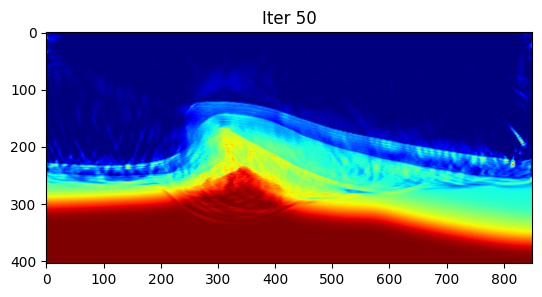

Epoch 060 | Norm Loss: 1.0702 | LR: 40.0000
Epoch 070 | Norm Loss: 0.9619 | LR: 40.0000
Epoch 080 | Norm Loss: 0.9007 | LR: 40.0000
Epoch 090 | Norm Loss: 0.8657 | LR: 40.0000
Epoch 100 | Norm Loss: 0.8479 | LR: 40.0000


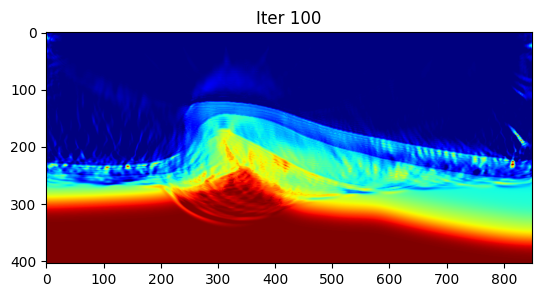

Epoch 110 | Norm Loss: 0.8411 | LR: 40.0000
Epoch 120 | Norm Loss: 0.8445 | LR: 40.0000
Epoch 130 | Norm Loss: 0.8503 | LR: 20.0000
Epoch 140 | Norm Loss: 0.8565 | LR: 20.0000


KeyboardInterrupt: 

In [10]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 200:] = 3500

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape

# 3. INITIAL MODEL
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=15)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)
vmin, vmax = v_true.min().item(), v_true.max().item()

# 4. GEOMETRY (CRITICAL FOR DEPTH)
pml_v = 20
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.003
nt = 2667   # 2667 * 0.003 = 8.001 SECONDS.
freq = 5.0
n_shots = 12

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 2
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 2
for i in range(n_shots): receiver_loc[i, :, 0] = rx

source_amp = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1).to(device)

# 5. GENERATE DATA
print(f"Generating data for {nt*dt:.2f} seconds...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
with torch.no_grad():
    for i in range(n_shots):
        out = scalar(v_true, spacing, dt, source_amplitudes=source_amp[i:i+1],
                     source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data[i] = out[-1]

# Pre-calculate initial loss for normalization
with torch.no_grad():
    initial_loss = 0
    for i in range(n_shots):
        out_init = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        initial_loss += torch.nn.MSELoss()(out_init[-1], observed_data[i:i+1]).item()
    initial_loss /= n_shots

# 6. DEPTH PRECONDITIONING
z = torch.linspace(0, 1, nz, device=device)
z_gain = (1.0 + 10.0 * z**2).view(1, nz)

# 7. INVERSION
optimizer = torch.optim.Adam([v1], lr=40.0)
# Added scheduler to reduce LR when loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
loss_history = []

print("Starting Top-to-Bottom Inversion...")
for epoch in range(300):
    optimizer.zero_grad()
    epoch_loss = 0

    for i in range(n_shots):
        out_pred = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)

        loss = torch.nn.MSELoss()(out_pred[-1], observed_data[i:i+1])
        (loss / initial_loss).backward()
        epoch_loss += (loss / initial_loss).item()
        del out_pred

    # Process Gradient
    with torch.no_grad():
        if v1.grad is not None:
            # Apply depth gain
            v1.grad *= z_gain

            # Apply Gradient Clipping to prevent instability/spikes
            torch.nn.utils.clip_grad_norm_(v1, max_norm=1.0)

            # Smooth the gradient
            grad_np = gaussian_filter(v1.grad.cpu().numpy(), sigma=2.5)
            v1.grad.copy_(torch.from_numpy(grad_np).to(device))

            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    # Update scheduler based on the epoch loss
    scheduler.step(epoch_loss)

    loss_history.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        curr_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:03d} | Norm Loss: {epoch_loss:.4f} | LR: {curr_lr:.4f}")

    if (epoch + 1) % 50 == 0:
        plt.figure(figsize=(8,3)); plt.imshow(v1.detach().cpu().numpy().T, cmap='jet'); plt.title(f"Iter {epoch+1}"); plt.show()
        gc.collect(); torch.cuda.empty_cache()

# 8. FINAL PLOTS
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = ["Initial Smooth", "FWI Final (Full Depth)", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i]); fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.grid(True)
plt.show()

Device: cuda
Generating data for 8.00s (Memory Safe)...
Starting Inversion (Fixing Flank Illumination)...
Epoch 010 | Norm Loss: 0.6252 | LR: 35.0000
Epoch 020 | Norm Loss: 0.2104 | LR: 35.0000
Epoch 030 | Norm Loss: 0.1173 | LR: 35.0000
Epoch 040 | Norm Loss: 0.0758 | LR: 35.0000
Epoch 050 | Norm Loss: 0.0562 | LR: 35.0000


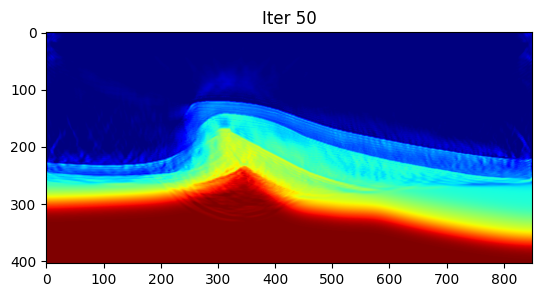

Epoch 060 | Norm Loss: 0.0456 | LR: 35.0000
Epoch 070 | Norm Loss: 0.0400 | LR: 35.0000
Epoch 080 | Norm Loss: 0.0370 | LR: 35.0000
Epoch 090 | Norm Loss: 0.0353 | LR: 35.0000
Epoch 100 | Norm Loss: 0.0344 | LR: 35.0000


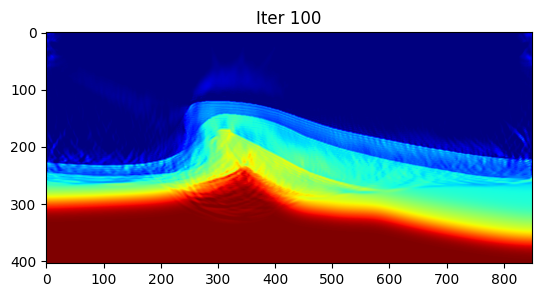

Epoch 110 | Norm Loss: 0.0338 | LR: 35.0000
Epoch 120 | Norm Loss: 0.0335 | LR: 35.0000
Epoch 130 | Norm Loss: 0.0333 | LR: 35.0000
Epoch 140 | Norm Loss: 0.0333 | LR: 35.0000


In [ ]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 0. INITIAL MEMORY CLEAN (Crucial for Colab)
gc.collect()
torch.cuda.empty_cache()

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 200:] = 3500

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape

# 3. INITIAL MODEL
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=15)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)
vmin, vmax = v_true.min().item(), v_true.max().item()

# 4. GEOMETRY (Optimized for Memory)
pml_v = 20
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.004  # Increased from 0.003 to 0.004 to save 25% GPU RAM
nt = 2000   # 2000 * 0.004 = 8.0 Seconds.
freq = 5.0
n_shots = 16

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 2
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 2
for i in range(n_shots): receiver_loc[i, :, 0] = rx

# Keep source wavelet on CPU to save GPU space
source_amp_cpu = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1)

# 5. GENERATE DATA (Sequential to stay under 15GB)
print(f"Generating data for {nt*dt:.2f}s (Memory Safe)...")
observed_data_cpu = torch.zeros(n_shots, n_receivers_per_shot, nt)

with torch.no_grad():
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out = scalar(v_true, spacing, dt, source_amplitudes=s_amp,
                     source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data_cpu[i] = out[-1].cpu()
        del out, s_amp
        torch.cuda.empty_cache()

# Pre-calculate initial loss for normalization
with torch.no_grad():
    initial_loss = 0
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out_init = scalar(v1, spacing, dt, source_amplitudes=s_amp,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        initial_loss += torch.nn.MSELoss()(out_init[-1], observed_data_cpu[i:i+1].to(device)).item()
        del out_init, s_amp
    initial_loss /= n_shots

# 6. ILLUMINATION COMPENSATION (Fix for the deep flanks)
z = torch.linspace(0, 1, nz, device=device)
z_gain = (1.0 + 35.0 * z**3).view(1, nz) # Cubic depth boost
x_gain = torch.ones(nx, device=device) # Edge boost for flanks
x_gain[:150] = torch.linspace(1.8, 1.0, 150, device=device)
x_gain[-150:] = torch.linspace(1.0, 1.8, 150, device=device)
full_gain = z_gain * x_gain.view(nx, 1)

# 7. INVERSION
optimizer = torch.optim.Adam([v1], lr=35.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=12)
loss_history = []

print("Starting Inversion (Fixing Flank Illumination)...")
for epoch in range(150):
    optimizer.zero_grad()
    epoch_loss = 0

    for i in range(n_shots):
        # Move only current shot to GPU
        curr_source = source_amp_cpu[i:i+1].to(device)
        curr_obs = observed_data_cpu[i:i+1].to(device)

        out_pred = scalar(v1, spacing, dt, source_amplitudes=curr_source,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)

        loss = torch.nn.MSELoss()(out_pred[-1], curr_obs)
        (loss / (initial_loss * n_shots)).backward()
        epoch_loss += (loss / initial_loss).item()

        # Immediate cleanup of heavy tensors
        del out_pred, curr_source, curr_obs
        torch.cuda.empty_cache()

    epoch_loss /= n_shots

    # Process Gradient
    with torch.no_grad():
        if v1.grad is not None:
            v1.grad *= full_gain # Apply illumination correction
            torch.nn.utils.clip_grad_norm_(v1, max_norm=0.8) # Prevent loss explosion
            grad = gaussian_filter(v1.grad.cpu().numpy(), sigma=2.0)
            v1.grad.copy_(torch.from_numpy(grad).to(device))
            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    scheduler.step(epoch_loss)
    loss_history.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | Norm Loss: {epoch_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.4f}")

    if (epoch + 1) % 50 == 0:
        plt.figure(figsize=(8,3)); plt.imshow(v1.detach().cpu().numpy().T, cmap='jet', vmin=vmin, vmax=vmax); plt.title(f"Iter {epoch+1}"); plt.show()
        gc.collect(); torch.cuda.empty_cache()

# 8. FINAL PLOTS
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = ["Initial Smooth", "FWI Final (Deep Illumination Fix)", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i]); fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout(); plt.show()

In [ ]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 0. INITIAL MEMORY CLEAN
gc.collect()
torch.cuda.empty_cache()

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    # Fallback if file not found
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 200:] = 3500

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape

# 3. INITIAL MODEL (INCREASED SMOOTHING AS REQUESTED)
# sigma increased from 15 to 40 to make it much blurrier
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=40)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)
vmin, vmax = v_true.min().item(), v_true.max().item()

# 4. GEOMETRY (Optimized for T4 15GB RAM)
pml_v = 20
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.004  # 0.004 helps memory compared to 0.003
nt = 2000   # 8 seconds total
freq = 5.0
n_shots = 16

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 2
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 2
for i in range(n_shots): receiver_loc[i, :, 0] = rx

source_amp_cpu = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1)

# 5. GENERATE OBSERVED DATA
print("Generating observed data (Sequential)...")
observed_data_cpu = torch.zeros(n_shots, n_receivers_per_shot, nt)
with torch.no_grad():
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out = scalar(v_true, spacing, dt, source_amplitudes=s_amp,
                     source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data_cpu[i] = out[-1].cpu()
        del out, s_amp
        torch.cuda.empty_cache()

# Initial Loss for Normalization
with torch.no_grad():
    initial_loss = 0
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out_init = scalar(v1, spacing, dt, source_amplitudes=s_amp,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        initial_loss += torch.nn.MSELoss()(out_init[-1], observed_data_cpu[i:i+1].to(device)).item()
        del out_init, s_amp
    initial_loss /= n_shots

# 6. ILLUMINATION & DEPTH GAIN
z = torch.linspace(0, 1, nz, device=device)
z_gain = (1.0 + 35.0 * z**3).view(1, nz) # Stronger depth reach
x_gain = torch.ones(nx, device=device)
x_gain[:150] = torch.linspace(1.8, 1.0, 150, device=device) # Flank boost
x_gain[-150:] = torch.linspace(1.0, 1.8, 150, device=device) # Flank boost
full_gain = z_gain * x_gain.view(nx, 1)

# 7. INVERSION
optimizer = torch.optim.Adam([v1], lr=35.0)
# Scheduler cuts LR to prevent loss increase after 100 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
loss_history = []

print(f"Starting Inversion from Highly Smoothed Model (Sigma=40)...")
for epoch in range(300):
    optimizer.zero_grad()
    epoch_loss = 0

    for i in range(n_shots):
        curr_source = source_amp_cpu[i:i+1].to(device)
        curr_obs = observed_data_cpu[i:i+1].to(device)

        out_pred = scalar(v1, spacing, dt, source_amplitudes=curr_source,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)

        loss = torch.nn.MSELoss()(out_pred[-1], curr_obs)
        (loss / (initial_loss * n_shots)).backward()
        epoch_loss += (loss / initial_loss).item()

        del out_pred, curr_source, curr_obs
        torch.cuda.empty_cache()

    epoch_loss /= n_shots

    # Process Gradient
    with torch.no_grad():
        if v1.grad is not None:
            v1.grad *= full_gain
            # Clamp gradients to maintain stability
            torch.nn.utils.clip_grad_norm_(v1, max_norm=0.8)

            # Smoothing gradient: Reduce smoothing as we progress to get sharper details
            current_sigma = max(2.5 * (0.99**epoch), 1.2)
            grad = gaussian_filter(v1.grad.cpu().numpy(), sigma=current_sigma)

            v1.grad.copy_(torch.from_numpy(grad).to(device))
            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    scheduler.step(epoch_loss)
    loss_history.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | Norm Loss: {epoch_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.4f}")

    if (epoch + 1) % 50 == 0:
        plt.figure(figsize=(8,3)); plt.imshow(v1.detach().cpu().numpy().T, cmap='jet', vmin=vmin, vmax=vmax); plt.title(f"Iter {epoch+1}"); plt.show()
        gc.collect(); torch.cuda.empty_cache()

# 8. FINAL PLOTS
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = [f"Initial Smooth (Sigma=40)", "FWI Final (Deep Illumination Fix)", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i]); fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout(); plt.show()

Device: cuda
Generating synthetic data from True Model...
Starting Inversion from Linear Gradient...
Epoch 010 | Norm Loss: 0.2904 | LR: 30.0000
Epoch 020 | Norm Loss: 0.1392 | LR: 30.0000
Epoch 030 | Norm Loss: 0.1027 | LR: 30.0000
Epoch 040 | Norm Loss: 0.0773 | LR: 30.0000
Epoch 050 | Norm Loss: 0.0635 | LR: 30.0000


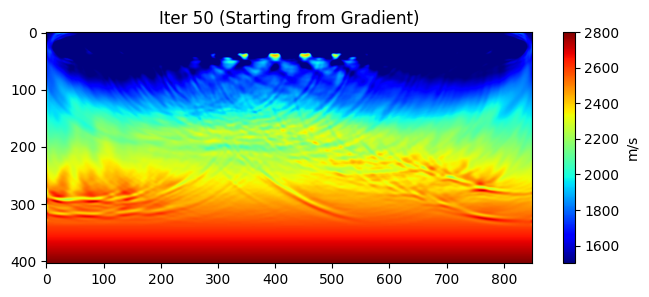

Epoch 060 | Norm Loss: 0.0556 | LR: 30.0000
Epoch 070 | Norm Loss: 0.0507 | LR: 30.0000
Epoch 080 | Norm Loss: 0.0453 | LR: 30.0000
Epoch 090 | Norm Loss: 0.0397 | LR: 30.0000
Epoch 100 | Norm Loss: 0.0354 | LR: 30.0000


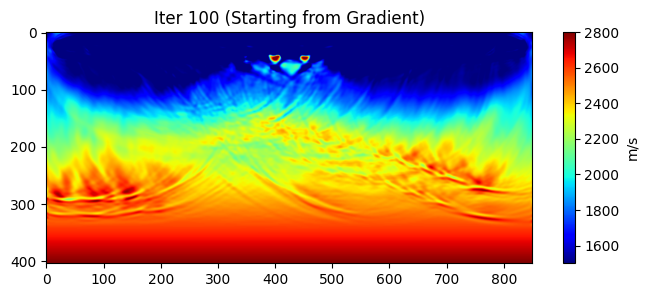

KeyboardInterrupt: 

In [3]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 0. INITIAL MEMORY CLEAN
gc.collect()
torch.cuda.empty_cache()

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    # Fallback if file not found
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 200:] = 3500

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape
vmin, vmax = v_true.min().item(), v_true.max().item()

# 3. INITIAL MODEL: SIMPLE LINEAR GRADIENT (Replaces Smooth Model)
# We create a 1D vertical profile and tile it across all X samples
v_top = vmin
v_bottom = vmax
v_gradient = np.linspace(v_top, v_bottom, nz).astype(np.float32)
v_init_np = np.tile(v_gradient, (nx, 1))

v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)

# 4. GEOMETRY (Optimized for T4 15GB RAM)
pml_v = 20
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.004  # CFL stable for 25m grid, saves 25% memory
nt = 2000   # 8.0 Seconds
freq = 5.0
n_shots = 16

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 2
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 2
for i in range(n_shots): receiver_loc[i, :, 0] = rx

source_amp_cpu = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1)

# 5. GENERATE OBSERVED DATA
print(f"Generating synthetic data from True Model...")
observed_data_cpu = torch.zeros(n_shots, n_receivers_per_shot, nt)

with torch.no_grad():
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out = scalar(v_true, spacing, dt, source_amplitudes=s_amp,
                     source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data_cpu[i] = out[-1].cpu()
        del out, s_amp
        torch.cuda.empty_cache()

# Calculate initial loss for normalization
with torch.no_grad():
    initial_loss = 0
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out_init = scalar(v1, spacing, dt, source_amplitudes=s_amp,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        initial_loss += torch.nn.MSELoss()(out_init[-1], observed_data_cpu[i:i+1].to(device)).item()
        del out_init, s_amp
    initial_loss /= n_shots

# 6. ILLUMINATION & DEPTH PRECONDITIONING
# Needed to help the anticline "grow" out of the linear gradient
z = torch.linspace(0, 1, nz, device=device)
z_gain = (1.0 + 40.0 * z**3).view(1, nz) # Strong cubic boost for depth

x_gain = torch.ones(nx, device=device) # Edge boost for flank illumination
x_gain[:150] = torch.linspace(2.0, 1.0, 150, device=device)
x_gain[-150:] = torch.linspace(1.0, 2.0, 150, device=device)
full_gain = z_gain * x_gain.view(nx, 1)

# 7. INVERSION
# Starting from a gradient requires a slightly lower LR initially for stability
optimizer = torch.optim.Adam([v1], lr=30.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
loss_history = []

print("Starting Inversion from Linear Gradient...")
for epoch in range(200):
    optimizer.zero_grad()
    epoch_loss = 0

    for i in range(n_shots):
        curr_source = source_amp_cpu[i:i+1].to(device)
        curr_obs = observed_data_cpu[i:i+1].to(device)

        out_pred = scalar(v1, spacing, dt, source_amplitudes=curr_source,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)

        loss = torch.nn.MSELoss()(out_pred[-1], curr_obs)
        # Gradient accumulation normalized by number of shots
        (loss / (initial_loss * n_shots)).backward()
        epoch_loss += (loss / initial_loss).item()

        del out_pred, curr_source, curr_obs
        torch.cuda.empty_cache()

    epoch_loss /= n_shots

    # Process Gradient
    with torch.no_grad():
        if v1.grad is not None:
            v1.grad *= full_gain
            # Stricter clipping for the first 50 epochs to stabilize gradient start
            clip_val = 0.5 if epoch < 50 else 0.8
            torch.nn.utils.clip_grad_norm_(v1, max_norm=clip_val)

            # Smooth gradient to prevent high-frequency noise artifacts
            grad = gaussian_filter(v1.grad.cpu().numpy(), sigma=2.5)
            v1.grad.copy_(torch.from_numpy(grad).to(device))

            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    scheduler.step(epoch_loss)
    loss_history.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | Norm Loss: {epoch_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.4f}")

    if (epoch + 1) % 50 == 0:
        plt.figure(figsize=(8,3))
        plt.imshow(v1.detach().cpu().numpy().T, cmap='jet', vmin=vmin, vmax=vmax)
        plt.title(f"Iter {epoch+1} (Starting from Gradient)")
        plt.colorbar(label='m/s')
        plt.show()
        gc.collect(); torch.cuda.empty_cache()

# 8. FINAL PLOTS
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = ["Initial Model (Linear Gradient)", "FWI Final Result", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i]); fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout(); plt.show()